In [74]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pyhf
import eos
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from redist import modifier
from redist import plot
from ksnunu_utils import * 

# Reinterpreting $B \to K^* \nu \nu$ in terms of the WET

Here the differential branching ratio prediction is a function of one kinematic variable: $q^2$.

We use $q^2$ also as the fitting variable, but with a different binning than for the reweighting.

## Define the binning

In [75]:
binning = np.linspace(0.0, 19.25, 11) 
bin_cents = (binning[:-1] + binning[1:])/2
q2binning = np.linspace(0.0, 19.25, 20)

## Define the NP model in WC space

In [76]:
cvl = 5.0
cvr = 1.0
csl = 1.0
csr = 1.0
ctl = 1.0

## Generate some SM samples

In [77]:
SMsamples = int(2e6) # factor 2 because BR(K*nunu) ~ 2*BR(Knunu)

p = analysis().parameters
k = eos.Kinematics(q2=1.0, q2_min=0.0, q2_max=19.25)
o = eos.Options(**{'form-factors': 'BSZ2015', 'model': 'WET'})

pdf = eos.SignalPDF.make('B^-->K^*-nunu::dGamma/dq2', p, k, o)
obs = eos.Observable.make('B->K^*nunu::BR', p, k, o)
SMBR = obs.evaluate()

null_samples, pdf_values = pdf.sample_mcmc(SMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=123))

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

### Smear samples with Gaussian resolution function and apply efficiency


In [78]:
np.random.seed(456)
null_samples_smeared = np.random.normal(null_samples, 1.0, null_samples.shape)
null_samples_smeared = np.abs(null_samples_smeared)

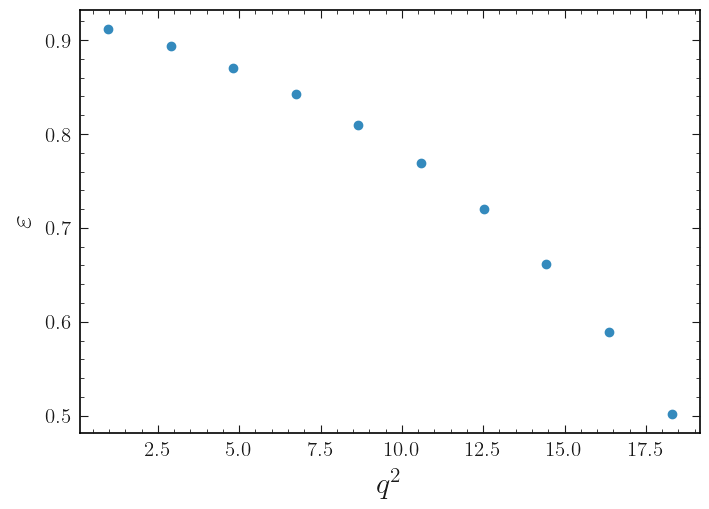

In [79]:
plt.plot(bin_cents, efficiency(bin_cents), "o")

plt.xlabel(r'$q^2$')
plt.ylabel(r'$\varepsilon$')
plt.show()

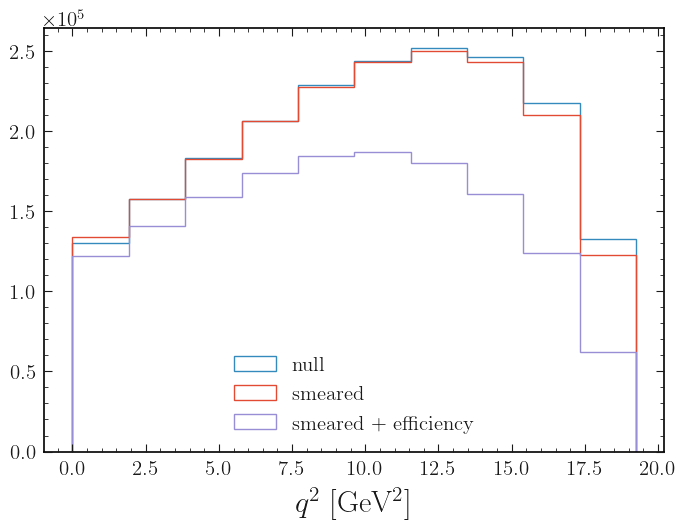

In [90]:
plt.hist(null_samples, binning, histtype='step', label='null')
plt.hist(null_samples_smeared, binning, histtype='step', label='smeared')
null_yields, _, _ = plt.hist(null_samples_smeared, binning, weights = efficiency(null_samples_smeared), histtype='step', label='smeared + efficiency')

plt.xlabel(r'$q^2$ [GeV$^2$]')
plt.legend()

## Generate some fake data according to some NP model

Need to scale the number of samples here, because if NP would exist, we would also see a total different count of events.

In [81]:
p['sbnunu::Re{cVL}'].set(cvl)
p['sbnunu::Re{cVR}'].set(cvr)
p['sbnunu::Re{cSL}'].set(csl)
p['sbnunu::Re{cSR}'].set(csr)
p['sbnunu::Re{cTL}'].set(ctl)

BSMBR = obs.evaluate()

BSMsamples = int(SMsamples*BSMBR/SMBR)
alt_samples, pdf_values = pdf.sample_mcmc(BSMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=789))

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

### Smear samples with Gaussian resolution function and apply efficiency


In [82]:
np.random.seed(101)
alt_samples_smeared = np.random.normal(alt_samples, 1.0, alt_samples.shape)
alt_samples_smeared = np.abs(alt_samples_smeared)

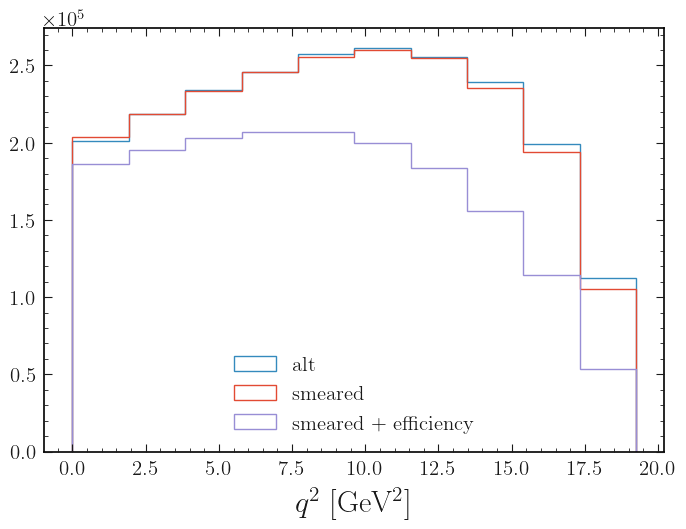

In [89]:
plt.hist(alt_samples, binning, histtype='step', label='alt')
plt.hist(alt_samples_smeared, binning, histtype='step', label='smeared')
alt_yields, _, _ = plt.hist(alt_samples_smeared, binning, weights = efficiency(alt_samples_smeared), histtype='step', label='smeared + efficiency')

plt.xlabel(r'$q^2$ [GeV$^2$]')
plt.legend()

## Set up the mapping distribution

In [100]:
mapping_dist = modifier.map(null_samples_smeared.flatten(), [null_samples.flatten()], binning, [q2binning])
mapping_dist = mapping_dist * efficiency(bin_cents)[:,np.newaxis]

## Set up the custom modifier

In [101]:
null = null_pred()
alt = alt_pred()

In [102]:
ana  = analysis()

v0   = ana.parameters['B->K^*::alpha^V_0@BSZ2015'  ].evaluate()
v1   = ana.parameters['B->K^*::alpha^V_1@BSZ2015'  ].evaluate()
v2   = ana.parameters['B->K^*::alpha^V_2@BSZ2015'  ].evaluate()

a00  = ana.parameters['B->K^*::alpha^A0_0@BSZ2015' ].evaluate() 
a01  = ana.parameters['B->K^*::alpha^A0_1@BSZ2015' ].evaluate() 
a02  = ana.parameters['B->K^*::alpha^A0_2@BSZ2015' ].evaluate()

a10  = ana.parameters['B->K^*::alpha^A1_0@BSZ2015' ].evaluate()
a11  = ana.parameters['B->K^*::alpha^A1_1@BSZ2015' ].evaluate()
a12  = ana.parameters['B->K^*::alpha^A1_2@BSZ2015' ].evaluate()

a121 = ana.parameters['B->K^*::alpha^A12_1@BSZ2015'].evaluate()
a122 = ana.parameters['B->K^*::alpha^A12_2@BSZ2015'].evaluate()

t10  = ana.parameters['B->K^*::alpha^T1_0@BSZ2015' ].evaluate()
t11  = ana.parameters['B->K^*::alpha^T1_1@BSZ2015' ].evaluate()
t12  = ana.parameters['B->K^*::alpha^T1_2@BSZ2015' ].evaluate()

t21  = ana.parameters['B->K^*::alpha^T2_1@BSZ2015' ].evaluate()
t22  = ana.parameters['B->K^*::alpha^T2_2@BSZ2015' ].evaluate()

t230 = ana.parameters['B->K^*::alpha^T23_0@BSZ2015'].evaluate()
t231 = ana.parameters['B->K^*::alpha^T23_1@BSZ2015'].evaluate()
t232 = ana.parameters['B->K^*::alpha^T23_2@BSZ2015'].evaluate()

In [139]:
# Get covariance matrix of hadronic parameters
cov = parameter_cov(alt.ana, chains = 1, samples = 20000)
pd.DataFrame(cov).style.background_gradient(cmap='RdBu')

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Markov chain self adaptation failed; trying diagonalization
Diagonalization succeeded


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.004075,0.065312,0.009928,0.001260,0.015117,-0.000036,0.028813,-0.011148,0.000462,-0.007221,-0.002944,0.001008,-0.012912,0.007837,-0.002805,0.000901,-0.001474,-0.038443,0.004063
1,0.065312,1.247048,-0.134499,0.018224,0.297192,0.034376,0.521443,-0.240601,0.001107,-0.035374,-0.038830,0.015365,-0.240995,0.285388,-0.068219,0.022789,-0.034256,-0.762547,0.076699
2,0.009928,-0.134499,1.702755,0.013207,-0.071571,-0.137324,-0.052260,0.218522,0.023314,-0.451277,-0.093543,0.008273,0.032359,-0.719305,0.078442,-0.012084,0.028298,0.354776,0.152933
3,0.001260,0.018224,0.013207,0.000601,0.004720,-0.000646,0.008124,-0.002168,0.000423,-0.003785,-0.001284,0.000490,-0.003582,-0.001014,0.000001,0.000152,-0.000170,-0.009926,0.004213
4,0.015117,0.297192,-0.071571,0.004720,0.080654,0.016453,0.125957,-0.065416,0.000147,0.019396,-0.003814,0.004203,-0.057924,0.095566,-0.016305,0.005303,-0.008279,-0.192262,0.032144
5,-0.000036,0.034376,-0.137324,-0.000646,0.016453,0.020901,0.014451,-0.025168,-0.002158,0.058222,0.011157,-0.000111,-0.007692,0.071521,-0.006448,0.001178,-0.002111,-0.035862,0.003973
6,0.028813,0.521443,-0.052260,0.008124,0.125957,0.014451,0.227149,-0.102030,0.000941,-0.013747,-0.014134,0.006797,-0.100186,0.119012,-0.027770,0.008844,-0.014070,-0.322169,0.023386
7,-0.011148,-0.240601,0.218522,-0.002168,-0.065416,-0.025168,-0.102030,0.079019,0.002238,-0.054353,-0.006178,-0.002286,0.054346,-0.138883,0.022172,-0.004102,0.008589,0.177274,-0.015572
8,0.000462,0.001107,0.023314,0.000423,0.000147,-0.002158,0.000941,0.002238,0.000726,-0.006585,-0.001496,0.000375,-0.000259,-0.008697,0.001425,-0.000195,0.000427,0.001569,0.003829
9,-0.007221,-0.035374,-0.451277,-0.003785,0.019396,0.058222,-0.013747,-0.054353,-0.006585,0.188239,0.040366,-0.001898,0.004407,0.207624,-0.012313,0.001036,-0.003528,-0.039368,-0.010921


In [140]:
cvlSM = eos.Parameters()['sbnunu::Re{cVL}'].evaluate()

new_params = {
                'cvl'   :{'inits': (cvlSM,), 'bounds': ((3., 9.),), 'paramset_type': 'unconstrained'},
                'cvr'   :{'inits': (0.01, ), 'bounds': ((0., 6.),), 'paramset_type': 'unconstrained'},
                'csl'   :{'inits': (0.01, ), 'bounds': ((0., 6.),), 'paramset_type': 'unconstrained'},
                'csr'   :{'inits': (0.01, ), 'bounds': ((0., 6.),), 'paramset_type': 'unconstrained'},
                'ctl'   :{'inits': (0.01, ), 'bounds': ((0., 6.),), 'paramset_type': 'unconstrained'},
                'FFKs'    :{'inits': (v0, v1, v2, a00, a01, a02, a10, a11, a12, a121, a122, t10, t11, t12, t21, t22, t230, t231, t232), 
                         'bounds': (), 
                         'cov': cov, 
                         'paramset_type': 'constrained_by_normal'}
            }

cmod = modifier.Modifier(new_params, alt.distribution, null.distribution, mapping_dist, [q2binning.tolist()], name='ksnunu')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(<Figure size 700x500 with 1 Axes>,
 <Axes: xlabel='$q^2$ [GeV$^2$]', ylabel='$d\\mathcal{B}/dq^2$'>)

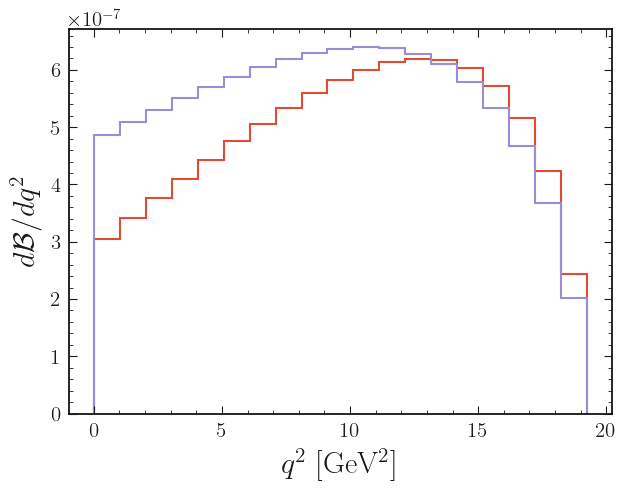

In [141]:
pars = (cvl, cvr, csl, csr, ctl, v0, v1, v2, a00, a01, a02, a10, a11, a12, a121, a122, t10, t11, t12, t21, t22, t230, t231, t232)
lims = [0.0, 19.25]
labels = [r'$q^2$ [GeV$^2$]', r'$d\mathcal{B}/dq^2$']
plot.dists(cmod, pars, lims, labels)

(<Figure size 800x550 with 2 Axes>,
 <Axes: xlabel='Kinematic bins', ylabel='Fitting bins'>)

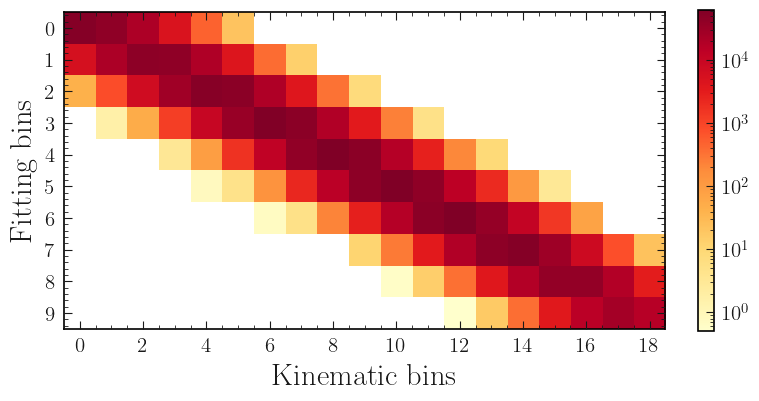

In [142]:
plot.map(cmod, cmap='YlOrRd', norm=LogNorm())

## Set up the model

In [143]:
spec = {
  "channels": [
    {
      "name": "B->K*nunu",
      "samples": [
        {
          "name": "signal",
          "data": null_yields.tolist(),
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            },
            {
                "name": "stat",
                "type": "staterror",
                "data": np.sqrt(null_yields).tolist()
            }
          ]
        },
      ]
    }
  ]
}
model = pyhf.Model(spec)

custom_mod = {
                "name": "ksnunu_theory",
                "type": "ksnunu",
                "data":
                    {"expr": "ksnunu_weight_fn"}
              }

model = modifier.add_to_model(model, ['B->K*nunu'], ['signal'], cmod.expanded_pyhf, custom_mod)
model.spec

{'channels': [{'name': 'B->K*nunu',
   'samples': [{'name': 'signal',
     'data': [122190.16286825041,
      140624.53497835726,
      159047.46120734647,
      174075.88814114354,
      184320.63891351933,
      186870.73103333276,
      180116.0813000959,
      160877.43966325186,
      124149.62267770339,
      62406.226917292224],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'stat',
       'type': 'staterror',
       'data': [349.5570952909559,
        374.99937997063046,
        398.8075490852028,
        417.22402632296183,
        429.32579576997153,
        432.2854740022301,
        424.4008497871981,
        401.0952999765166,
        352.34872311064703,
        249.81238343463326]},
      {'name': 'ksnunu_theory',
       'type': 'ksnunu',
       'data': {'expr': 'ksnunu_weight_fn'}}]}]}]}

## Save and load model

In [144]:
modifier.save('ksnunu_model.json', model.spec, cmod, alt_yields)
model, alt_yields = modifier.load('ksnunu_model.json', alt.distribution, null.distribution, return_data=True)

data = alt_yields + model.config.auxdata

## Perform the fit

In [145]:
fixed = model.config.suggested_fixed()
fixed[model.config.par_map['mu']['slice']] = [True]
# fixed[model.config.par_map['cvr']['slice']] = [True]
fixed[model.config.par_map['csr']['slice']] = [True]

pyhf.set_backend("numpy", pyhf.optimize.scipy_optimizer())
best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed)
pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=True, strategy=2))
best_fit, twice_nll, OptimizeResult = pyhf.infer.mle.fit(
    data,
    model,
    init_pars=best_fit.tolist(),
    fixed_params=fixed,
    return_uncertainties=True,
    return_fitted_val=True,
    return_result_obj=True
    )

best_fit_dict = modifier.par_dict(model, best_fit)
best_fit_dict


W MnPosDef Matrix forced pos-def by adding to diagonal 0.350905
W MnPosDef Matrix forced pos-def by adding to diagonal 0.0202032
W MnPosDef Matrix forced pos-def by adding to diagonal 0.0201918
W MnPosDef Matrix forced pos-def by adding to diagonal 0.020772
W MnPosDef Matrix forced pos-def by adding to diagonal 0.0210615
W MnPosDef Matrix forced pos-def by adding to diagonal 0.0605268


{'cvl': array([3.06113214, 0.02265726]),
 'cvr': array([0.035369  , 0.03278667]),
 'csl': array([3.15219019, 0.03886116]),
 'csr': array([0.01, 0.  ]),
 'ctl': array([1.07326366, 0.00231794]),
 'FFKs_decorrelated[0]': array([-0.34175984,  0.01149212]),
 'FFKs_decorrelated[1]': array([-0.21285273,  0.00971405]),
 'FFKs_decorrelated[2]': array([-0.01802822,  0.14581272]),
 'FFKs_decorrelated[3]': array([0.0184073 , 0.14052575]),
 'FFKs_decorrelated[4]': array([-0.0342726 ,  0.13367688]),
 'FFKs_decorrelated[5]': array([0.0470508 , 0.06153684]),
 'FFKs_decorrelated[6]': array([0.05074336, 0.06494086]),
 'FFKs_decorrelated[7]': array([0.00580215, 0.14231968]),
 'FFKs_decorrelated[8]': array([0.00745011, 0.15041428]),
 'FFKs_decorrelated[9]': array([-0.01328336,  0.27146009]),
 'FFKs_decorrelated[10]': array([-0.02169537,  0.34449288]),
 'FFKs_decorrelated[11]': array([0.00809942, 0.21820123]),
 'FFKs_decorrelated[12]': array([0.03265417, 0.08791244]),
 'FFKs_decorrelated[13]': array([-0.05

In [146]:
best_fit_rot = cmod.rotate_pars({k:v[0] if len(np.shape(v))==1 else [p[0] for p in v] for k, v in best_fit_dict.items()})
best_fit_rot

{'cvl': 3.061132143920606,
 'cvr': 0.03536899866985808,
 'csl': 3.1521901872013105,
 'csr': 0.01,
 'ctl': 1.0732636553114347,
 'FFKs[0]': 0.3623601412038021,
 'FFKs[1]': -0.9867963273556978,
 'FFKs[2]': 2.2806275060525185,
 'FFKs[3]': 0.3381541797436181,
 'FFKs[4]': -1.111871286817187,
 'FFKs[5]': 2.4192621995837014,
 'FFKs[6]': 0.33279081479361444,
 'FFKs[7]': 0.37903573492710896,
 'FFKs[8]': 1.2162040606717572,
 'FFKs[9]': 0.6902038425875897,
 'FFKs[10]': 0.6064006978876709,
 'FFKs[11]': 0.3167408309594208,
 'FFKs[12]': -0.981779491874607,
 'FFKs[13]': 2.323364882783865,
 'FFKs[14]': 0.5647452714060915,
 'FFKs[15]': 1.684503566852378,
 'FFKs[16]': 0.610343361325458,
 'FFKs[17]': 0.8325756062480092,
 'FFKs[18]': 1.7903380913693805,
 'mu': 1.0,
 'stat': [0.9996514905385446,
  0.9998632387613079,
  1.001406875759708,
  0.99972058804385,
  0.9992535652433666,
  0.999936742853372,
  0.9996273740271774,
  0.9992175635331502,
  1.003624023338066,
  0.9963643270275173]}

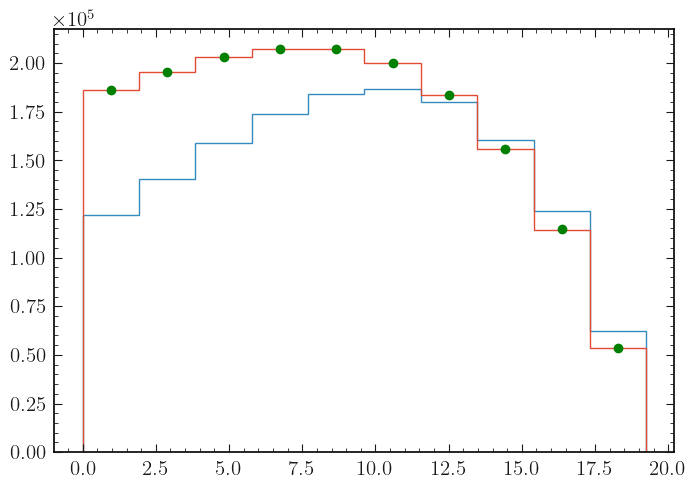

In [147]:
plt.stairs(model.expected_actualdata(model.config.suggested_init()), binning)
plt.stairs(model.expected_actualdata(best_fit[:,0]), binning)
bin_cents = (binning[:-1] + binning[1:])/2
plt.plot(bin_cents, alt_yields, 'og')